In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from pysim import SimBoostRegressor, SimBoostClassifier

## Regression

```python
from pysim import SimBoostRegressor
clf = SimBoostRegressor(n_estimators, stein_method="first_order", spline="a_spline", learning_rate=0.1, reg_lambda=0.1, reg_gamma=0.1, knot_dist="uniform", degree=2, knot_num=20, ortho_shrink=1, loss_threshold=0.01, val_ratio=0.2, random_state=0)
```

In [4]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])

beta = np.vstack([beta1, beta2, beta3])
model_list = [lambda x: 0.2 * np.exp(-4 * x), lambda x: 3 * x ** 2, lambda x: 2.5 * np.sin(1.5 * np.pi * x)]

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(20000, 10), random_state=random_state)
noise = np.random.randn(20000).reshape(-1, 1)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [29]:
%%time 

clf = SimBoostRegressor(n_estimators=50, knot_num=20, knot_dist="uniform", spline="a_spline", learning_rate=0.5,
                        reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5],
                        reg_gamma=[0.1, 1, 10])
clf.fit(train_x, train_y, inner_update=False)

CPU times: user 11min 24s, sys: 26min 24s, total: 37min 48s
Wall time: 36.7 s


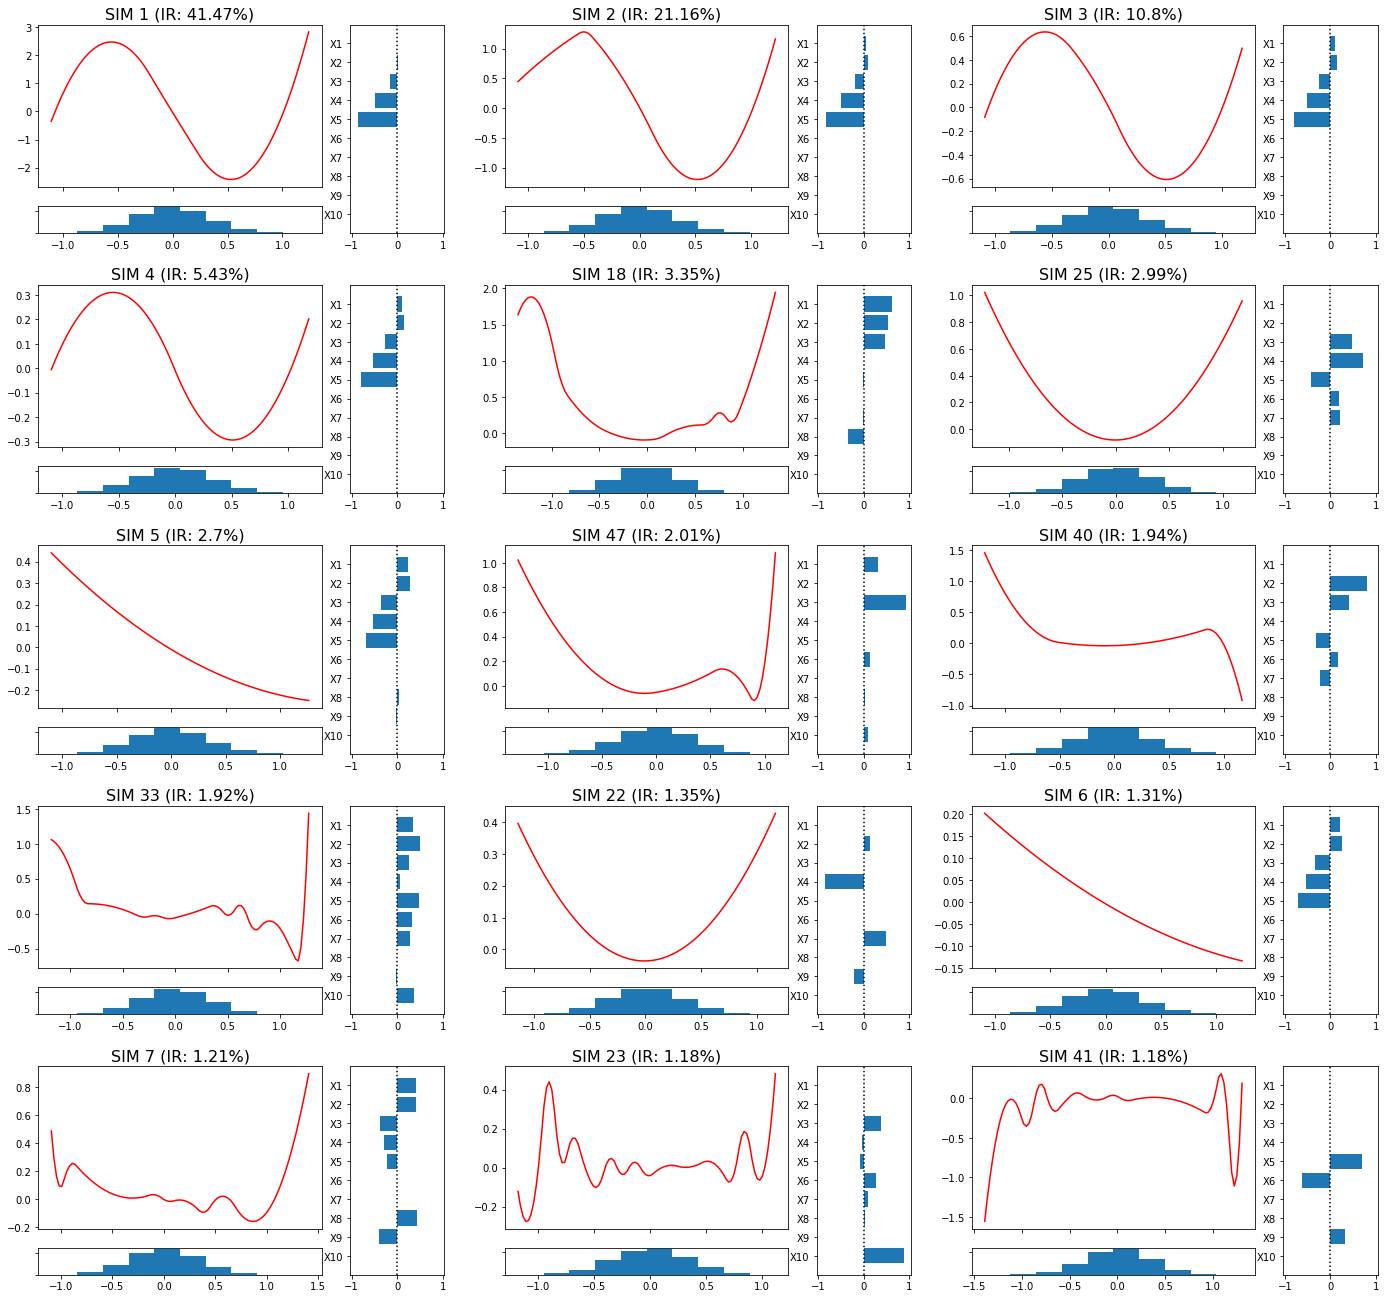

In [30]:
clf.visualize()

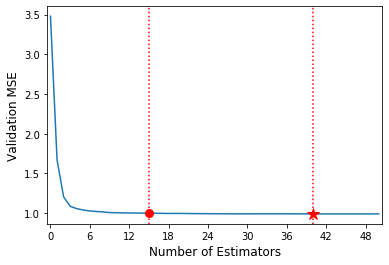

In [31]:
clf.validation_performance()

In [32]:
mean_squared_error(test_y, clf.predict(test_x))

1.0432364682223065

In [33]:
%%time 

clf = SimBoostRegressor(n_estimators=50, knot_num=20, knot_dist="uniform", spline="smoothing_spline", learning_rate=0.5,
                        reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5],
                        reg_gamma=[0.1, 0.5])
clf.fit(train_x, train_y, inner_update=False)

CPU times: user 15min 33s, sys: 36min 30s, total: 52min 4s
Wall time: 51.1 s


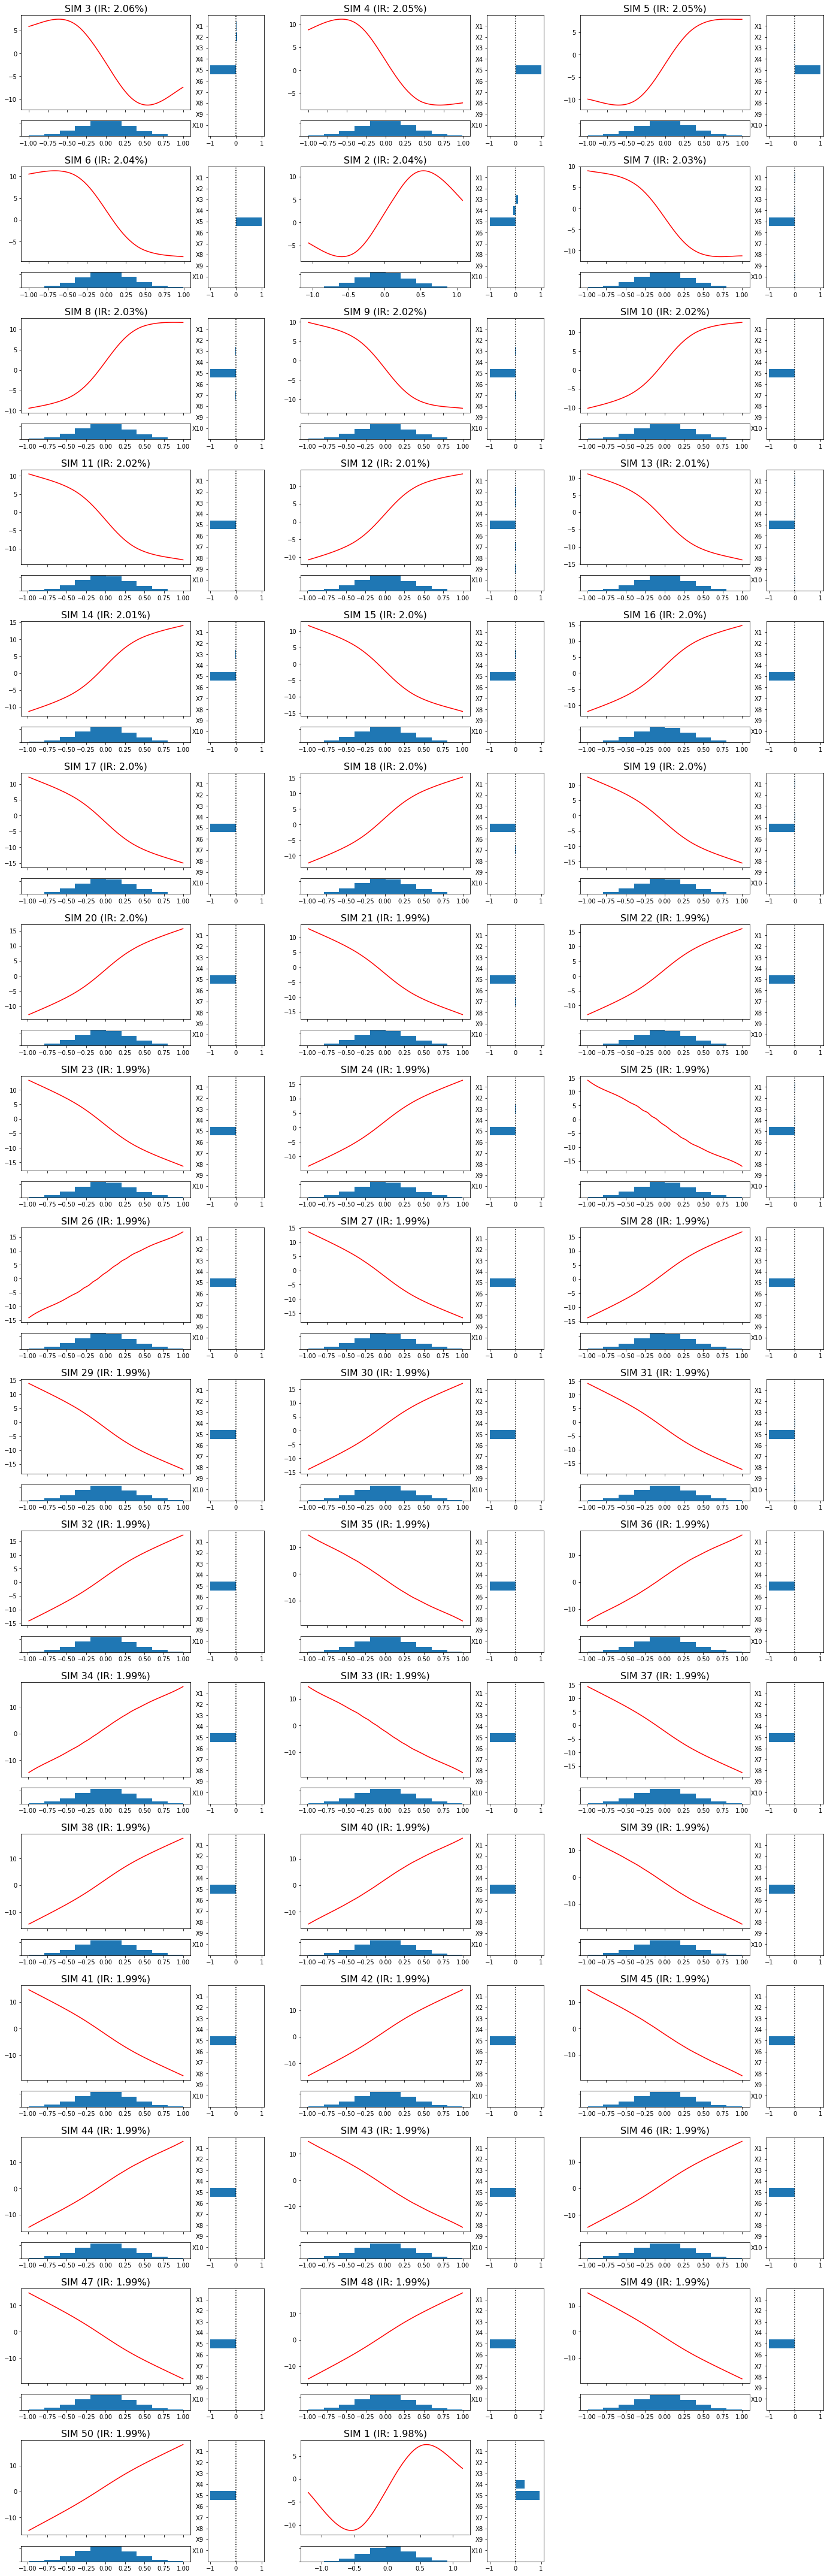

In [34]:
clf.visualize()

In [42]:
from pysim import SimRegressor

In [55]:
sim = SimRegressor(knot_num=20, spline="smoothing_spline")
sim.fit(train_x, train_y)
sim.predict(train_x), mean_squared_error(test_y, sim.predict(test_x))

(array([-6.00510667, -5.9668054 ,  6.594426  , ..., -9.59578838,
        -1.68213009, -9.65730002]), 23.686439440913375)

In [59]:
xb = np.dot(train_x, sim.beta_)

In [61]:
sim.shape_fit_.predict(xb)

array([-6.00510667, -5.9668054 ,  6.594426  , ..., -9.59578838,
       -1.68213009, -9.65730002])

In [62]:

import rpy2
from rpy2 import robjects as ro
from rpy2.robjects import Formula
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri, pandas2ri

numpy2ri.activate()
pandas2ri.activate()

try:
    stats = importr("stats")
except:
    utils = importr('utils')
    utils.install_packages('stats', repos='http://cran.us.r-project.org')
    stats = importr("stats")

np.array(stats.predict_smooth_spline(sim.sm_, xb, deriv=0)[1]).ravel()

AttributeError: 'SimRegressor' object has no attribute 'sm_'

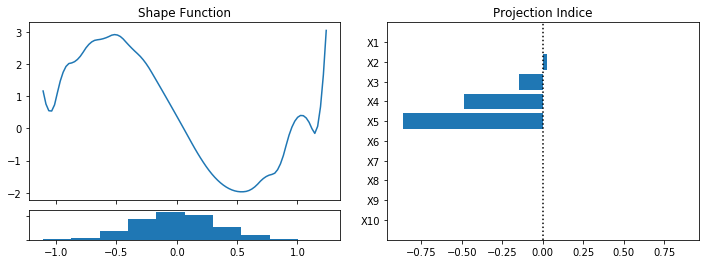

In [54]:
sim.visualize()

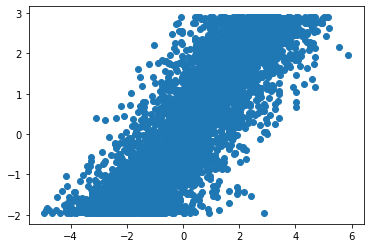

In [52]:
plt.scatter(test_y, sim.predict(test_x))

In [35]:
mean_squared_error(test_y, clf.predict(test_x))

3.2909995027860273

## LogitBoost

```python
from pysim import SimBoostClassifier
clf = SimBoostClassifier(n_estimators, stein_method="first_order", spline="a_spline", learning_rate=0.1, reg_lambda=0.1, reg_gamma=0.1, knot_dist="uniform", degree=2, knot_num=20, ortho_shrink=1, loss_threshold=0.01, val_ratio=0.2, random_state=0)
```

In [7]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
beta = np.vstack([beta1, beta2, beta3])

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(10000, 10), random_state=random_state)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + \
    np.random.randn(10000).reshape(-1, 1)
y[y <= 0] = 0
y[y > 0] = 1
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [8]:
%%time 

clf = SimBoostClassifier(n_estimators=50, knot_num=20, knot_dist="uniform", spline="a_spline", learning_rate=0.5,
                         reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5],
                         reg_gamma=[0.1, 1, 10])
clf.fit(train_x, train_y, inner_update=False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1291, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/simboost.py", line 508, in fit
    self._fit(x, y, sample_weight, inner_update)
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/simboost.py", line 745, in _fit
    sample_weight=sample_weight, proj_mat=proj_mat, val_ratio=self.val_ratio)
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py", line 227, in fit_inner_update
    dfxb = self.shape_fit_.diff(xb, order=1)
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/splines/smspline.py", line 67, in diff
    derivative = np.array(stats.predict(self.sm_, x, deriv=order)[1]).ravel()
  File "/home/r7user1/anaconda2_local/envs/tf

KeyboardInterrupt: 

In [9]:
clf.visualize()

NotFittedError: This SimBoostClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
clf.validation_performance()

In [ ]:
roc_auc_score(test_y, clf.predict_proba(test_x))